# AR sampling in DeepSensor

## Set-up

In [5]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [6]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.convnp import ConvNP

In [7]:
from deepsensor.active_learning.algorithms import GreedyAlgorithm

from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds, construct_circ_time_ds

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import lab as B
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")
from tqdm import tqdm

In [9]:
crs = ccrs.LambertAzimuthalEqualArea(0, -90)
test_date = pd.Timestamp("2014-01-01")

In [10]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [11]:
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc').sel(time=slice("1990-01-01", None))
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 11323, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [12]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [13]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)
era5_ds = data_processor(era5_raw_ds, method="mean_std")
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.314, std=3.883
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [14]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

In [15]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [16]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="cnp")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]
decoder_scale inferred from TaskLoader: 0.005988023952095809


In [17]:
train_tasks = task_loader(pd.date_range("1990-01-01", "2014-12-31", freq="D")[::30], (0.1, "all"), "all")

In [23]:
for i in range(1):
    losses = train_epoch(model, train_tasks, progress_bar=True)

100%|██████████████████████████████████████████████████████████████████| 305/305 [00:25<00:00, 11.92it/s]


## AR sampling

In [19]:
# Rather than training, we will load some pre-trained weights
load_weights = True
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("../model.h5")
    elif deepsensor.backend.str == "torch":
        import torch
        model.model.load_state_dict(torch.load("../model.pt"))

In [20]:
task = task_loader("2014-12-31", context_sampling=(40, "all"), target_sampling="all")
task

time: Timestamp/2014-12-31 00:00:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 40)', ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_c: ['ndarray/float32/(1, 40)', 'ndarray/float32/(6, 280, 280)']
X_t: [('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_t: ['ndarray/float32/(1, 280, 280)']

In [21]:
mean, std, samples = model.predict(task, X_t=era5_raw_ds, n_samples=5, ar_sample=True, ar_subsample_factor=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


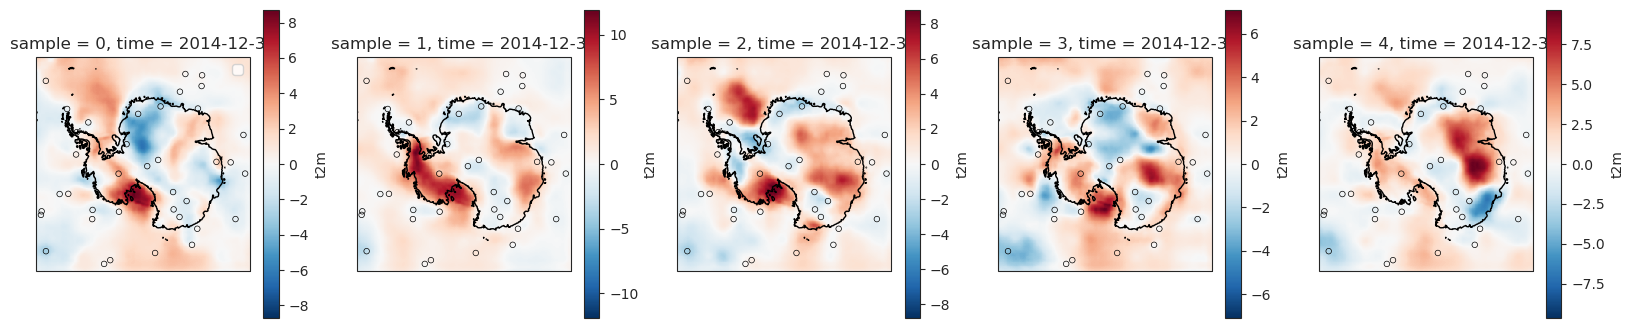

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(20, 4), subplot_kw={"projection": crs})
for i, ax in enumerate(axes):
    samples.t2m.isel(time=0, sample=i).plot(ax=ax)
    ax.coastlines()
deepsensor.plot.offgrid_context(axes, task, data_processor, task_loader, s=4**2, linewidths=0.5)